In [1]:
pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from torchvision.datasets import VOCDetection
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
import random

def get_voc_subset(limit=200, year='2007', image_set='trainval'):
    dataset = VOCDetection(
        root='./',
        year=year,
        image_set=image_set,
        download=True,
        transform=ToTensor()
    )
    # Shuffle and pick a subset of indices
    indices = random.sample(range(len(dataset)), limit)
    return Subset(dataset, indices)


In [3]:
from torch.utils.data import Dataset
import torch

class VOCDatasetWrapper(Dataset):
    def __init__(self, voc_dataset):
        self.voc_dataset = voc_dataset
        self.class_to_idx = {
            'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4,
            'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9,
            'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13,
            'motorbike': 14, 'person': 15, 'pottedplant': 16,
            'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20
        }

    def __len__(self):
        return len(self.voc_dataset)

    def __getitem__(self, idx):
        img, target = self.voc_dataset[idx]
        objects = target['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]

        boxes, labels = [], []
        for obj in objects:
            bbox = obj['bndbox']
            boxes.append([
                float(bbox['xmin']),
                float(bbox['ymin']),
                float(bbox['xmax']),
                float(bbox['ymax'])
            ])
            labels.append(self.class_to_idx[obj['name']])

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        return img, target


In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [5]:
import torch
import torch.utils.data
import time
from tqdm import tqdm
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, targets in tqdm(dataloader, desc="Training"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(dataloader)



In [6]:
pip install torchmetrics


Note: you may need to restart the kernel to use updated packages.


In [7]:
from torchvision.datasets import VOCDetection

def get_voc_dataset(split='trainval', year='2007', root='./'):
    return VOCDetection(root=root, year=year, image_set=split, download=True, transform=ToTensor())


In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ Use smaller training set
base_dataset = get_voc_subset(limit=200, image_set='trainval')
wrapped_dataset = VOCDatasetWrapper(base_dataset)

def collate_fn(batch):
    return tuple(zip(*batch))

# ✅ Use smaller validation set
val_base = get_voc_subset(limit=100, image_set='test')
val_dataset = VOCDatasetWrapper(val_base)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

# 🧠 Evaluation Function
def evaluate_map(model, dataloader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            preds = [
                {
                    'boxes': out['boxes'].cpu(),
                    'scores': out['scores'].cpu(),
                    'labels': out['labels'].cpu()
                }
                for out in outputs
            ]
            gts = [
                {
                    'boxes': t['boxes'].cpu(),
                    'labels': t['labels'].cpu()
                }
                for t in targets
            ]
            metric.update(preds, gts)

    results = metric.compute()
    return results["map"].item()


100%|██████████| 460M/460M [00:16<00:00, 27.2MB/s]


Extracting ./VOCtrainval_06-Nov-2007.tar to ./


100%|██████████| 451M/451M [00:13<00:00, 33.6MB/s]


Extracting ./VOCtest_06-Nov-2007.tar to ./


In [9]:
import matplotlib.pyplot as plt

# Store metrics for plotting
results = {
    'settings': [],
    'losses': [],
    'maps': [],
    'inference_results': []  # ➕ Store inference results
}

# 🔁 Loop over different LR and batch size settings
settings = [
    {'lr': 0.005, 'batch_size': 1},
    {'lr': 0.001, 'batch_size': 2},
    {'lr': 0.0005, 'batch_size': 4}
]

for setting in settings:
    print(f"🔧 Training with LR={setting['lr']} and Batch Size={setting['batch_size']}")
    dataloader = DataLoader(wrapped_dataset, batch_size=setting['batch_size'], shuffle=True, collate_fn=collate_fn)

    model = get_model(num_classes=21)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=setting['lr'], momentum=0.9, weight_decay=0.0005)

    losses = []
    for epoch in range(5):
        avg_loss = train_one_epoch(model, dataloader, optimizer, device)
        print(f"📉 Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
        losses.append(avg_loss)

    # 🧪 Evaluate mAP
    mAP = evaluate_map(model, val_loader, device)
    print(f"✅ mAP: {mAP:.4f}")

    # 🖼️ Run inference on sample image
    model.eval()
    sample_img, _ = wrapped_dataset[0]
    with torch.no_grad():
        prediction = model([sample_img.to(device)])[0]

    # Convert prediction to CPU numpy arrays for later plotting
    pred_boxes = prediction["boxes"].cpu().numpy()
    pred_labels = prediction["labels"].cpu().numpy()
    pred_scores = prediction["scores"].cpu().numpy()

    print("🔍 Sample prediction:", {
        "boxes": pred_boxes,
        "labels": pred_labels,
        "scores": pred_scores
    })

    # 💾 Store for plotting
    results['settings'].append(setting)
    results['losses'].append(losses)
    results['maps'].append(mAP)
    results['inference_results'].append({
        "image": sample_img.cpu(),  # 💡 Save image tensor for plotting
        "boxes": pred_boxes,
        "labels": pred_labels,
        "scores": pred_scores
    })

    print("-" * 60)


🔧 Training with LR=0.005 and Batch Size=1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 205MB/s]
Training: 100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


📉 Epoch 1, Loss: 0.6971


Training: 100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


📉 Epoch 2, Loss: 0.5411


Training: 100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


📉 Epoch 3, Loss: 0.4665


Training: 100%|██████████| 200/200 [00:54<00:00,  3.65it/s]


📉 Epoch 4, Loss: 0.3993


Training: 100%|██████████| 200/200 [00:55<00:00,  3.63it/s]


📉 Epoch 5, Loss: 0.3323
✅ mAP: 0.2036
🔍 Sample prediction: {'boxes': array([[200.19853 ,  64.37212 , 324.83017 , 210.16873 ],
       [110.42274 ,  92.58609 , 381.72006 , 351.57733 ],
       [389.41504 , 169.64761 , 474.2506  , 391.5351  ],
       [113.31978 ,  57.398067, 351.93588 , 223.44522 ],
       [147.44798 , 132.34807 , 346.1856  , 267.45242 ],
       [109.7873  ,  77.57425 , 354.00015 , 241.9479  ],
       [385.39444 , 134.10101 , 473.64786 , 389.48026 ],
       [391.5224  ,  96.389336, 471.00003 , 387.19177 ],
       [180.64886 , 130.1123  , 382.63266 , 260.34885 ],
       [212.93713 , 104.12494 , 318.00015 , 184.27788 ],
       [336.33536 , 166.46783 , 464.4762  , 361.77725 ],
       [152.48001 , 105.77335 , 406.09186 , 280.43307 ],
       [185.21968 , 152.04764 , 368.6114  , 265.28714 ],
       [195.87247 ,  68.66422 , 397.0873  , 344.17834 ],
       [ 77.4199  , 123.377815, 131.16191 , 371.3093  ],
       [154.31544 , 145.03226 , 437.36072 , 375.03204 ]], dtype=float32), 'l

Training: 100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


📉 Epoch 1, Loss: 0.8583


Training: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


📉 Epoch 2, Loss: 0.5937


Training: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


📉 Epoch 3, Loss: 0.4757


Training: 100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


📉 Epoch 4, Loss: 0.3972


Training: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


📉 Epoch 5, Loss: 0.3317
✅ mAP: 0.3265
🔍 Sample prediction: {'boxes': array([[201.15163 ,  52.755928, 314.6402  , 201.91626 ],
       [ 82.605484,  63.75667 , 408.19357 , 343.4602  ],
       [162.97249 ,  42.346313, 345.15002 , 231.86798 ],
       [110.67661 ,  92.96295 , 385.21643 , 237.67256 ],
       [ 82.36392 ,  89.50347 , 132.48627 , 347.591   ],
       [ 95.254555,  62.381947, 280.846   , 285.868   ],
       [168.46768 ,  16.751568, 396.15506 , 316.05844 ],
       [227.58296 ,  75.78852 , 478.56598 , 394.      ],
       [ 76.017105,  90.66987 , 389.76593 , 383.93564 ],
       [122.151306, 105.47484 , 480.      , 343.56097 ],
       [192.06557 ,  56.32945 , 436.77554 , 326.2431  ],
       [143.5702  ,  84.89284 , 444.25565 , 248.03912 ]], dtype=float32), 'labels': array([15, 13, 15, 13, 15, 13, 15, 13, 14, 10,  2, 14]), 'scores': array([0.99543035, 0.8019981 , 0.640091  , 0.33789143, 0.1910739 ,
       0.17565548, 0.11285153, 0.087223  , 0.08537512, 0.07941478,
       0.07324889, 

Training: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


📉 Epoch 1, Loss: 1.1430


Training: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


📉 Epoch 2, Loss: 0.7195


Training: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


📉 Epoch 3, Loss: 0.6709


Training: 100%|██████████| 50/50 [01:07<00:00,  1.36s/it]


📉 Epoch 4, Loss: 0.6348


Training: 100%|██████████| 50/50 [01:06<00:00,  1.34s/it]


📉 Epoch 5, Loss: 0.5914
✅ mAP: 0.1353
🔍 Sample prediction: {'boxes': array([[199.2033   ,  57.57171  , 306.6764   , 198.33044  ],
       [152.31027  ,  53.13867  , 363.04208  , 225.62607  ],
       [104.18501  ,  37.67876  , 384.6103   , 300.4218   ],
       [ 82.35099  ,  93.27003  , 130.46515  , 372.7613   ],
       [121.28446  ,  37.85193  , 278.0484   , 260.4776   ],
       [177.45287  ,  42.88757  , 314.65945  , 338.0823   ],
       [189.69867  ,  79.84359  , 388.911    , 365.35757  ],
       [219.63013  ,  56.519848 , 273.57623  , 219.03577  ],
       [400.93512  , 119.34138  , 476.8322   , 370.76318  ],
       [ 78.51559  ,  28.6146   , 246.61292  , 385.89465  ],
       [220.3917   ,  35.324203 , 470.16495  , 307.39154  ],
       [ 24.535711 ,  48.20284  , 480.       , 204.66423  ],
       [ 86.64391  , 140.41504  , 470.6496   , 361.81284  ],
       [ 94.71836  , 121.34147  , 460.13052  , 372.48978  ],
       [106.71775  ,  62.145535 , 428.5553   , 270.9971   ],
       [ 57.6221

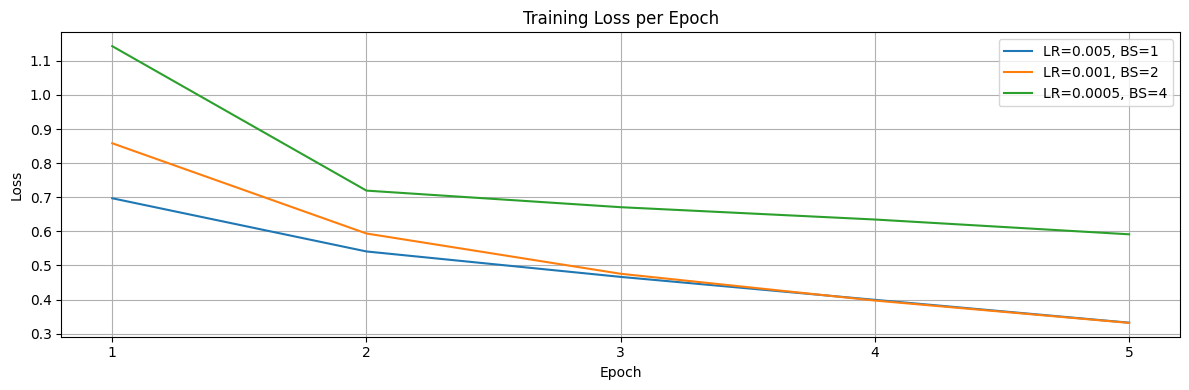

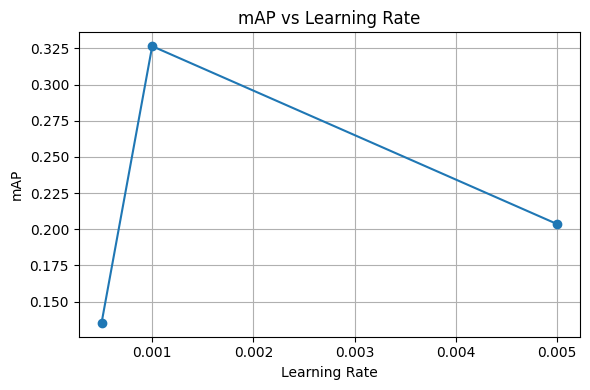

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import matplotlib.patches as patches

# 1. 📉 Plot Loss curves
plt.figure(figsize=(12, 4))
num_epochs = len(results['losses'][0])  # Assuming all losses have the same length
epochs = list(range(1, num_epochs + 1))  # Ensure it starts from 1

for i, setting in enumerate(results['settings']):
    plt.plot(epochs, results['losses'][i], label=f"LR={setting['lr']}, BS={setting['batch_size']}")

plt.xticks(epochs)  # Ensure all epoch numbers are shown
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. 🎯 Plot mAP vs Learning Rate
plt.figure(figsize=(6, 4))
lrs = [s['lr'] for s in results['settings']]
maps = results['maps']
plt.plot(lrs, maps, marker='o')
plt.title("mAP vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("mAP")
plt.grid(True)
plt.tight_layout()
plt.show()

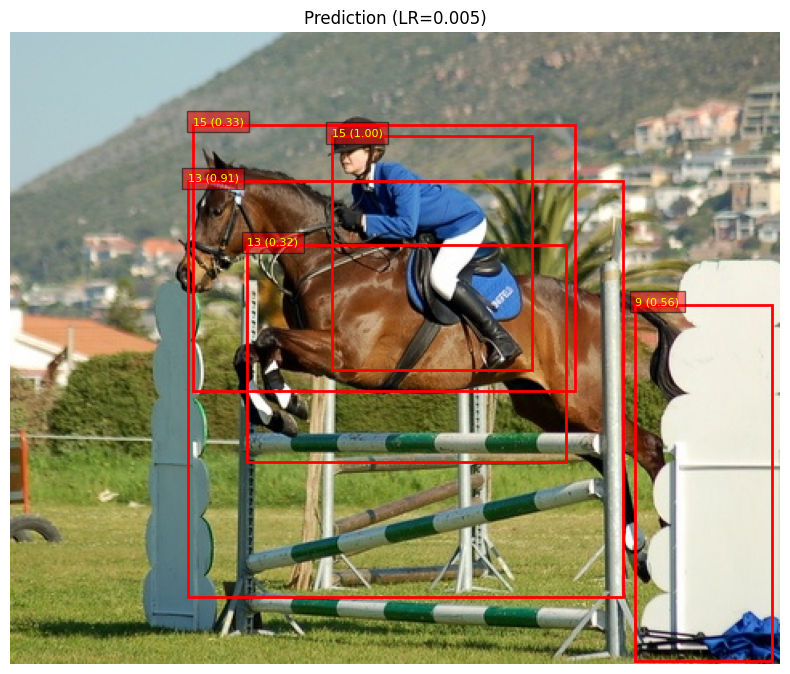

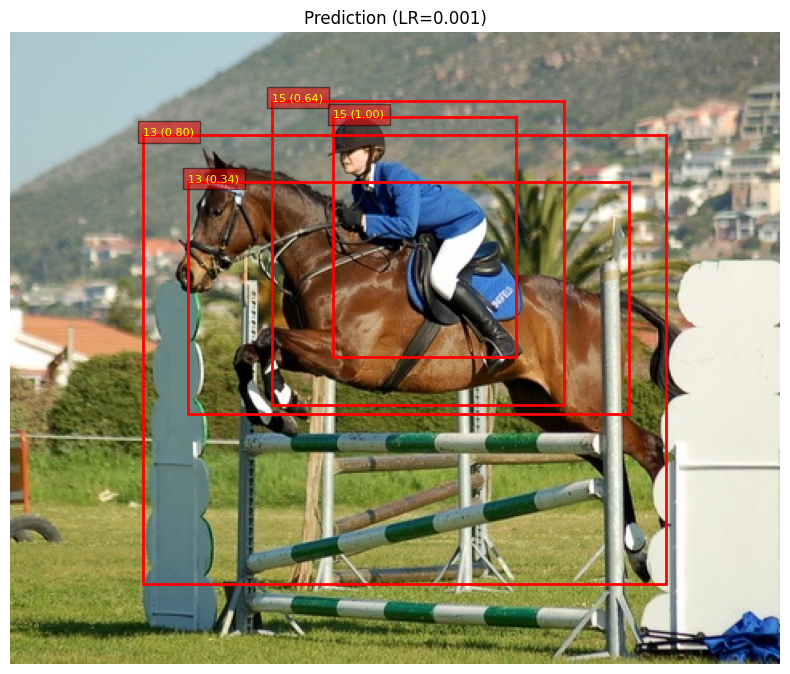

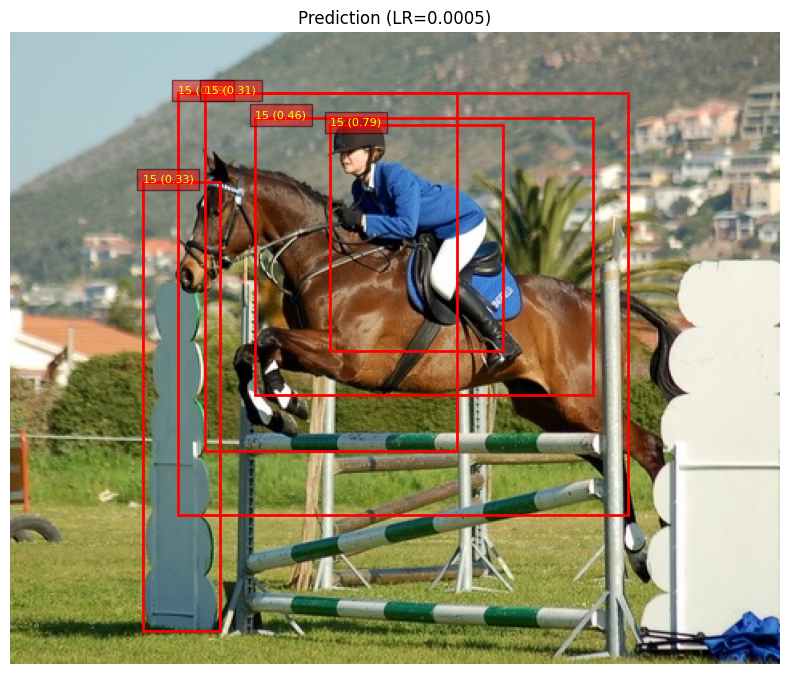

In [11]:
# 3. 🖼️ Show prediction results on sample image
for i, result in enumerate(results['inference_results']):
    img = result['image']
    boxes = result['boxes']
    scores = result['scores']
    labels = result['labels']

    # Convert tensor image to PIL-compatible format
    img_np = F.to_pil_image(img)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img_np)
    ax.set_title(f"Prediction (LR={results['settings'][i]['lr']})")

    for box, label, score in zip(boxes, labels, scores):
        if score < 0.25:
            continue  # filter out low confidence
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"{label} ({score:.2f})", color='yellow',
                fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.tight_layout()
    plt.show()
